<a href="https://colab.research.google.com/github/kalisetty23/NLP_ASSIGNMENT_3/blob/main/M3_Part_I_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)##Assignment 3 Naïve Bayes and Sentiment Classification and Logistic Regression
Instructions
* Read the following Chapter 4: Naive Bayes and Sentiment Classification. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.
* Read the following Chapter 5: Logistic Regression. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.

Summary
Classification is one of the most important tasks of NLP and in machine learning. In NLP it often means the task of text categorization for both sentiment analysis, spam detection, and topic modeling. Naïve Bayes is often one of the first classification algorithms defined in NLP.  The intuition behind a classifier is lies at the underlying probability inferred by the Bayesian Inference, which uses Baye’s rule and conditional probabilities.

Here’s a reminder on Baye’s Rule:
P(y)=P(x)P(x)/(P(y))

We are saying “what is the probability of x given y”. Naïve Bayes is a generative model because there is an input that helps the model determine what the output could be. Said differently, “to train a generative model we first collect a large amount of data in some domain (e.g., think millions of images, sentences, or sounds, etc.) and then train a model to generate data like it.” [6]

So in the case of Naïve Bayes, we say given some word, what should be the class of the current word we are assessing? Contrastingly, discriminative models such as logistic regression, learn from features provided to the algorithm and then determine or predict what the class is. [7]


With Naïve Bayes, the assumption is that the probabilities are independent. We often call the Naïve Bayes classifier the bag-of-words approach. That’s because we are essentially throwing in the collection of words into a ‘bag’, selecting a word at random, and then calculating their frequency to use in the Bayesian Inference. Thus, context – the position of words -- is ignored and despite this, it turns out that the Naïve Bayes approach can be accurate and effective at determining whether an email is spam for example.

Back to bag of words. With bag of words, we assume that the position of the words are not relevant -- that dependency or context in the word phrase or sentence doesn’t matter. Relatedly, the naive Bayes assumption implies that the conditional probabilities are independent -- a rather strange assumption to make for words in a sentence! The equation for the naive Bayes classifier is outlined below:

You can use Naive Bayes by creating an index of words and walking through every word position in a test or corpus.


It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.

For this Assignment, you can start with a spam/ham dataset, then predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).   One example corpus:   https://spamassassin.apache.org/old/publiccorpus/

You may work alone or in a group on this project.  You're welcome to use any tools or approach that you like.  Due before our next meetup. Starter code provided below.

Test example is provided at the end.

Libraries you may wish to use

In [1]:
import pandas as pd
import numpy as np
from os import makedirs, path, remove, rename, rmdir
from tarfile import open as open_tar
from shutil import rmtree
from urllib import request, parse
from glob import glob
from os import path
from re import sub
from email import message_from_file
from glob import glob
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import gc


download corpus using the following functions

Note: you may need to mount your drive on google then run this location. See previous exercises.

In [2]:
def download_corpus(dataset_dir: str = 'data'):
    base_url = 'https://spamassassin.apache.org'
    corpus_path = 'old/publiccorpus'
    files = {
        '20021010_easy_ham.tar.bz2': 'ham',
        '20021010_hard_ham.tar.bz2': 'ham',
        '20021010_spam.tar.bz2': 'spam',
        '20030228_easy_ham.tar.bz2': 'ham',
        '20030228_easy_ham_2.tar.bz2': 'ham',
        '20030228_hard_ham.tar.bz2': 'ham',
        '20030228_spam.tar.bz2': 'spam',
        '20030228_spam_2.tar.bz2': 'spam',
        '20050311_spam_2.tar.bz2': 'spam' }

    #creates the folders: downloads, ham and spam
    downloads_dir = path.join(dataset_dir, 'downloads')
    ham_dir = path.join(dataset_dir, 'ham')
    spam_dir = path.join(dataset_dir, 'spam')

    makedirs(downloads_dir, exist_ok=True)
    makedirs(ham_dir, exist_ok=True)
    makedirs(spam_dir, exist_ok=True)


    for file, spam_or_ham in files.items():
        # download files from URL of each specific .bz2 file
        url = parse.urljoin(base_url, f'{corpus_path}/{file}')
        tar_filename = path.join(downloads_dir, file)
        request.urlretrieve(url, tar_filename)

        #list e-mails in the compressed .bz2 file
        emails = []
        with open_tar(tar_filename) as tar:
            tar.extractall(path=downloads_dir)
            for tarinfo in tar:
                if len(tarinfo.name.split('/')) > 1:
                    emails.append(tarinfo.name)

        # move e-mails to ham or spam directory
        for email in emails:
            directory, filename = email.split('/')
            directory = path.join(downloads_dir, directory)

            if not path.exists(path.join(dataset_dir, spam_or_ham, filename)):
                rename(path.join(directory, filename),
                   path.join(dataset_dir, spam_or_ham, filename))

        rmtree(directory)

download_corpus()

In [3]:
download_corpus()

#How many e-mails are classified in our dataset as either Spam or not Spam?


In [4]:
#How many e-mails are classified in our dataset as either Spam or not Spam?
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('Number of Non-Spam E-mails:', len(glob(f'{ham_dir}/*')))
print('\nNumber of Spam E-mails:', len(glob(f'{spam_dir}/*')))

Number of Non-Spam E-mails: 6952

Number of Spam E-mails: 2399


Provide your classifier below

In [5]:
# Preprocessing functions
def clean_text(text):
    text = sub(r'\W+', ' ', text.lower())  # Remove non-word characters and convert to lowercase
    text = sub(r'\s+', ' ', text)  # Remove extra whitespaces
    return text.strip()

def extract_text_from_email(email_path):
    with open(email_path, 'r', errors='ignore') as f:
        email_message = message_from_file(f)
        if email_message.is_multipart():
            for part in email_message.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain':
                    text = part.get_payload(decode=True).decode(errors='ignore')
                    return clean_text(text)
        else:
            return clean_text(email_message.get_payload(decode=True).decode(errors='ignore'))



In [6]:
# Load the dataset
ham_files = len(glob(f'{ham_dir}/*'))
spam_files = len(glob(f'{spam_dir}/*'))
emails = [(extract_text_from_email(file), 'ham') for file in glob(f'{ham_dir}/*')] + [(extract_text_from_email(file), 'spam') for file in glob(f'{spam_dir}/*')]

df = pd.DataFrame(emails, columns=['text', 'label'])

df

,text,label
0,to view this newsletter in full color visit ht...,ham
1,url http boingboing net 85531557 date not supp...,ham
2,adam l beberg wrote did someone invert the spa...,ham
3,this article from nytimes com has been sent to...,ham
4,gary lawrence murphy ok but only if you also m...,ham
...,...,...
9346,what does it mean to be made in the usa cna is...,spam
9347,help wanted we are a 14 year old fortune 500 c...,spam
9348,diversified underwriters services inc impaired...,spam
9349,saved from url 0022 http internet e mail html ...,spam


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [7]:
# Split the dataset into training and testing sets
# Split the dataset into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
test_set = pd.DataFrame(columns=['text', 'label'])
for train_index, test_index in split.split(df, df['label']):
    test_set['text'].fillna('', inplace=True)
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [15]:
test_set

,text,label
6278,spamtalk said probably better than the spam ph...,ham
7992,non med level term 15 20 30 year with return o...,spam
9161,targeted email marketing works there s no way ...,spam
2255,gary lawrence murphy wrote r r a hettinga rah ...,ham
5226,matthias haase wrote the bytecode interpreter ...,ham
...,...,...
523,on tue jul 23 2002 at 06 16 02pm 0400 tabor j ...,ham
4835,hmm i ve never used gentoo so i ll have to tak...,ham
8413,our delightful garden ornaments combine the fi...,spam
2999,reza b far wrote this thread kind of surprises...,ham


In [9]:
train_index

array([8637, 7210, 1194, ..., 3050, 2772, 1556])

In [10]:
train_set

,text,label
8637,we thought you may be interested in our new so...,spam
7210,html body bgcolor fffbe0 center font face verd...,spam
1194,date wed 31 jul 2002 23 11 49 0800 from fergal...,ham
7809,increase your revenues by accepting credit car...,spam
6706,url http www newsisfree com click 0 8357893 21...,ham
...,...,...
8851,guaranteed to increase lift and firm your brea...,spam
5520,this is due to insufficient write privileges t...,ham
3050,hi are there any reasons _not_ to use the new ...,ham
2772,on tue 2002 09 10 at 12 39 matthias saou wrote...,ham


In [11]:
# Train the Naive Bayes classifier
class NaiveBayesClassifier:
    def __init__(self):
        self.word_counts = defaultdict(partial(defaultdict, int))
        self.class_counts = defaultdict(int)

    def train(self, X_train, y_train):
        for text, label in zip(X_train, y_train):
            for word in text.split():
                self.word_counts[label][word] += 1
                self.class_counts[label] += 1


    def predict(self, X_test):
       predictions = []
       for text in X_test:
           if text is None:
               predictions.append('ham')  # Return a default prediction for None values
               continue
           ham_prob = np.log(self.class_counts['ham'] / sum(self.class_counts.values()))
           spam_prob = np.log(self.class_counts['spam'] / sum(self.class_counts.values()))
           for word in text.split():
               ham_prob += np.log((self.word_counts['ham'][word] + 1) / (self.class_counts['ham'] + len(self.word_counts['ham'])))
               spam_prob += np.log((self.word_counts['spam'][word] + 1) / (self.class_counts['spam'] + len(self.word_counts['spam'])))
           prediction = 'spam' if spam_prob > ham_prob else 'ham'
           predictions.append(prediction)
       return predictions

In [12]:
# Train and evaluate the classifier
classifier = NaiveBayesClassifier()
train_set['text'].fillna('', inplace=True)
classifier.train(train_set['text'], train_set['label'])
predictions = classifier.predict(test_set['text'])

# Evaluate the performance
print('Accuracy:', accuracy_score(test_set['label'], predictions))
print('Precision:', precision_score(test_set['label'], predictions, average='weighted'))
print('Recall:', recall_score(test_set['label'], predictions, average='weighted'))
print('F1-Score:', f1_score(test_set['label'], predictions, average='weighted'))




Accuracy: 0.977552111170497
Precision: 0.977805933788488
Recall: 0.977552111170497
F1-Score: 0.9772927140775599


Confusion Matrix:
[[1386    5]
 [  37  443]]


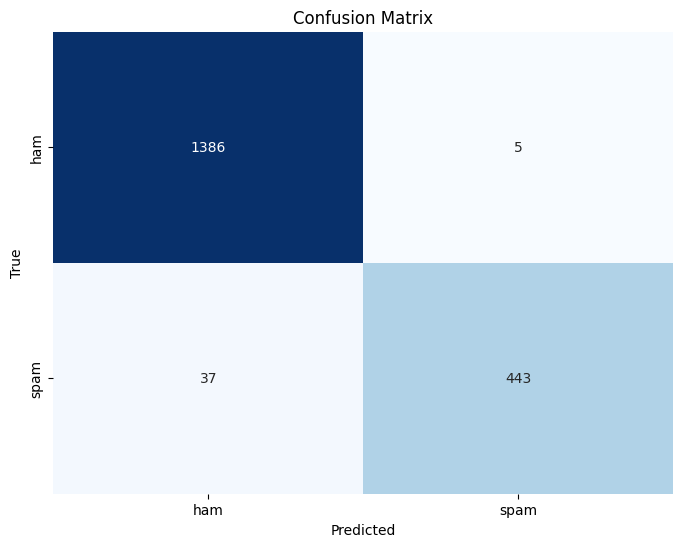

In [13]:
# Calculating  the confusion matrix
cm = confusion_matrix(test_set['label'], predictions)
print("Confusion Matrix:")
print(cm)
# Creating a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The following email is a test email. You can take this and test your classifier to see if it predicts spam or not.



In [14]:
spam_email = """
Subject: Get Rich Quick!

Dear Friend,

Congratulations! You've been selected to participate in an exclusive opportunity to make thousands of dollars from the comfort of your own home. Our revolutionary system guarantees quick and easy cash with minimal effort.

No more struggling to pay bills or worrying about financial security. With our proven method, you can start earning massive amounts of money in no time.

Here's what some of our satisfied customers have to say:
- "I was skeptical at first, but I'm now living my dream life thanks to this incredible system!" - John S.
- "I never thought making money online could be this simple. It's changed my life!" - Sarah L.

Don't miss out on this limited-time offer. Act now to secure your spot and start enjoying a life of financial freedom.

Click the link below to get started:
www.getrichquick.com

Remember, this opportunity is exclusive and won't last long. Take control of your financial future today!

Best regards,
The Get Rich Quick Team
"""
test_email = clean_text(spam_email)
prediction = classifier.predict([test_email])[0]
print('Predicted Label:', prediction)

Predicted Label: spam
